In [4]:
import os

import xarray as xr
import numpy as np
import torch
from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc

import matplotlib
import matplotlib.pyplot as plt

import copy
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes

import cartopy.crs as ccrs
from datetime import datetime

In [2]:
names = ["Constant", "ReduceLROnPlateau", "StepLR", "CosineAnnealingLR", "CosineAnnealingWarmRestarts", "CosineAnnealingWarmupRestarts"]
ds_id = "A7B509"

In [12]:
for name in names:
    os.system("sbatch submit_script_5_lr_schedule_selection.sh -d {} -l {}".format(ds_id, name))

Submitted batch job 41759167
Submitted batch job 41759168
Submitted batch job 41759169
Submitted batch job 41759170
Submitted batch job 41759171
Submitted batch job 41759172


In [3]:
model_ids = ["23CD86","04EA1C", "8DFE77", "7AB0CF", "2DB6A9", "4206A6"]
model_ids_mse_loss = ["8F3861","0F3525", "D359F7", "2464FD", "30604C", "5C39F8"]

In [7]:
for model_id in model_ids_mse_loss:
    os.system("sbatch submit_script_3_eval.sh -d {} -m {} -e {}".format(ds_id, model_id, 1))

Submitted batch job 41809543
Submitted batch job 41809544
Submitted batch job 41809545
Submitted batch job 41809546
Submitted batch job 41809547
Submitted batch job 41809548


In [4]:
predictions_experiments = {}
targets_experiments = {}


for model_id in model_ids_mse_loss:
    predictions_experiments[model_id] = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_gen.nc")
    targets_experiments[model_id] = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_target.nc")

In [6]:
rmse_maps = {}
rmse = {}
r2 = {}
r2_maps = {}

for model_id in model_ids_mse_loss:
    rmse[model_id] = compute_weighted_rmse(predictions_experiments[model_id].isel({"ensemble_member":0}), targets_experiments[model_id].isel({"ensemble_member":0}))
    rmse_maps[model_id] = compute_weighted_rmse(predictions_experiments[model_id].isel({"ensemble_member":0}), targets_experiments[model_id].isel({"ensemble_member":0}), mean_dims=("init_time", "lead_time"))
    print("{}, RMSE is {:.1f}".format(model_id, rmse[model_id].z_500.values))

8F3861, RMSE is 826.5
0F3525, RMSE is 826.2
D359F7, RMSE is 824.4
2464FD, RMSE is 817.3
30604C, RMSE is 815.6
5C39F8, RMSE is 824.5


# Plotting

In [9]:
n_images = 3
timesteps = np.random.choice(np.arange(len(predictions_experiments["30604C"])), size=(n_images,))

In [10]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

In [11]:
# do configurations for plotting - these can also be shared or "inherited" for plots that are similar!

config = {
    "CMAP": "viridis",
    "NORM": matplotlib.colors.Normalize(vmin=49000, vmax=59000),
    "RASTERIZED": True, # don't plot map pixels as individual points to make created files smaller
    "SHOW_COLORBAR": True,
    "CBAR_ORIENTATION": "horizontal",
    "CBAR_EXTEND": "both",
    "SHOW_COLORBAR_LABEL": True,
    "CBAR_LABEL": r"Geopotential [$m^2/s^2$]",
    "TITLE": "",
    "TITLE_FONTSIZE": 8,
    "PROJECTION": ccrs.Robinson(), # this is not called by plot_map, but by the function we create the entire plot with.
    "ASPECT_RATIO": 6/5  # can be used to calculate a figsize that looks nice for a given type of plot
}


config_diff = copy.deepcopy(config)

config_diff["CMAP"] = "RdBu"
config_diff["NORM"] = matplotlib.colors.Normalize(vmin=-3000, vmax=3000)

In [12]:
targets_experiments["30604C"]

<xarray.Dataset>
Dimensions:          (lat: 32, lon: 64, lead_time: 1, ensemble_member: 1,
                      init_time: 17419)
Coordinates:
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lead_time        (lead_time) int64 72
  * ensemble_member  (ensemble_member) int64 0
  * init_time        (init_time) datetime64[ns] 1970-01-01T00:00:00.000333126...
Data variables:
    z_500            (ensemble_member, init_time, lead_time, lat, lon) float32 ...

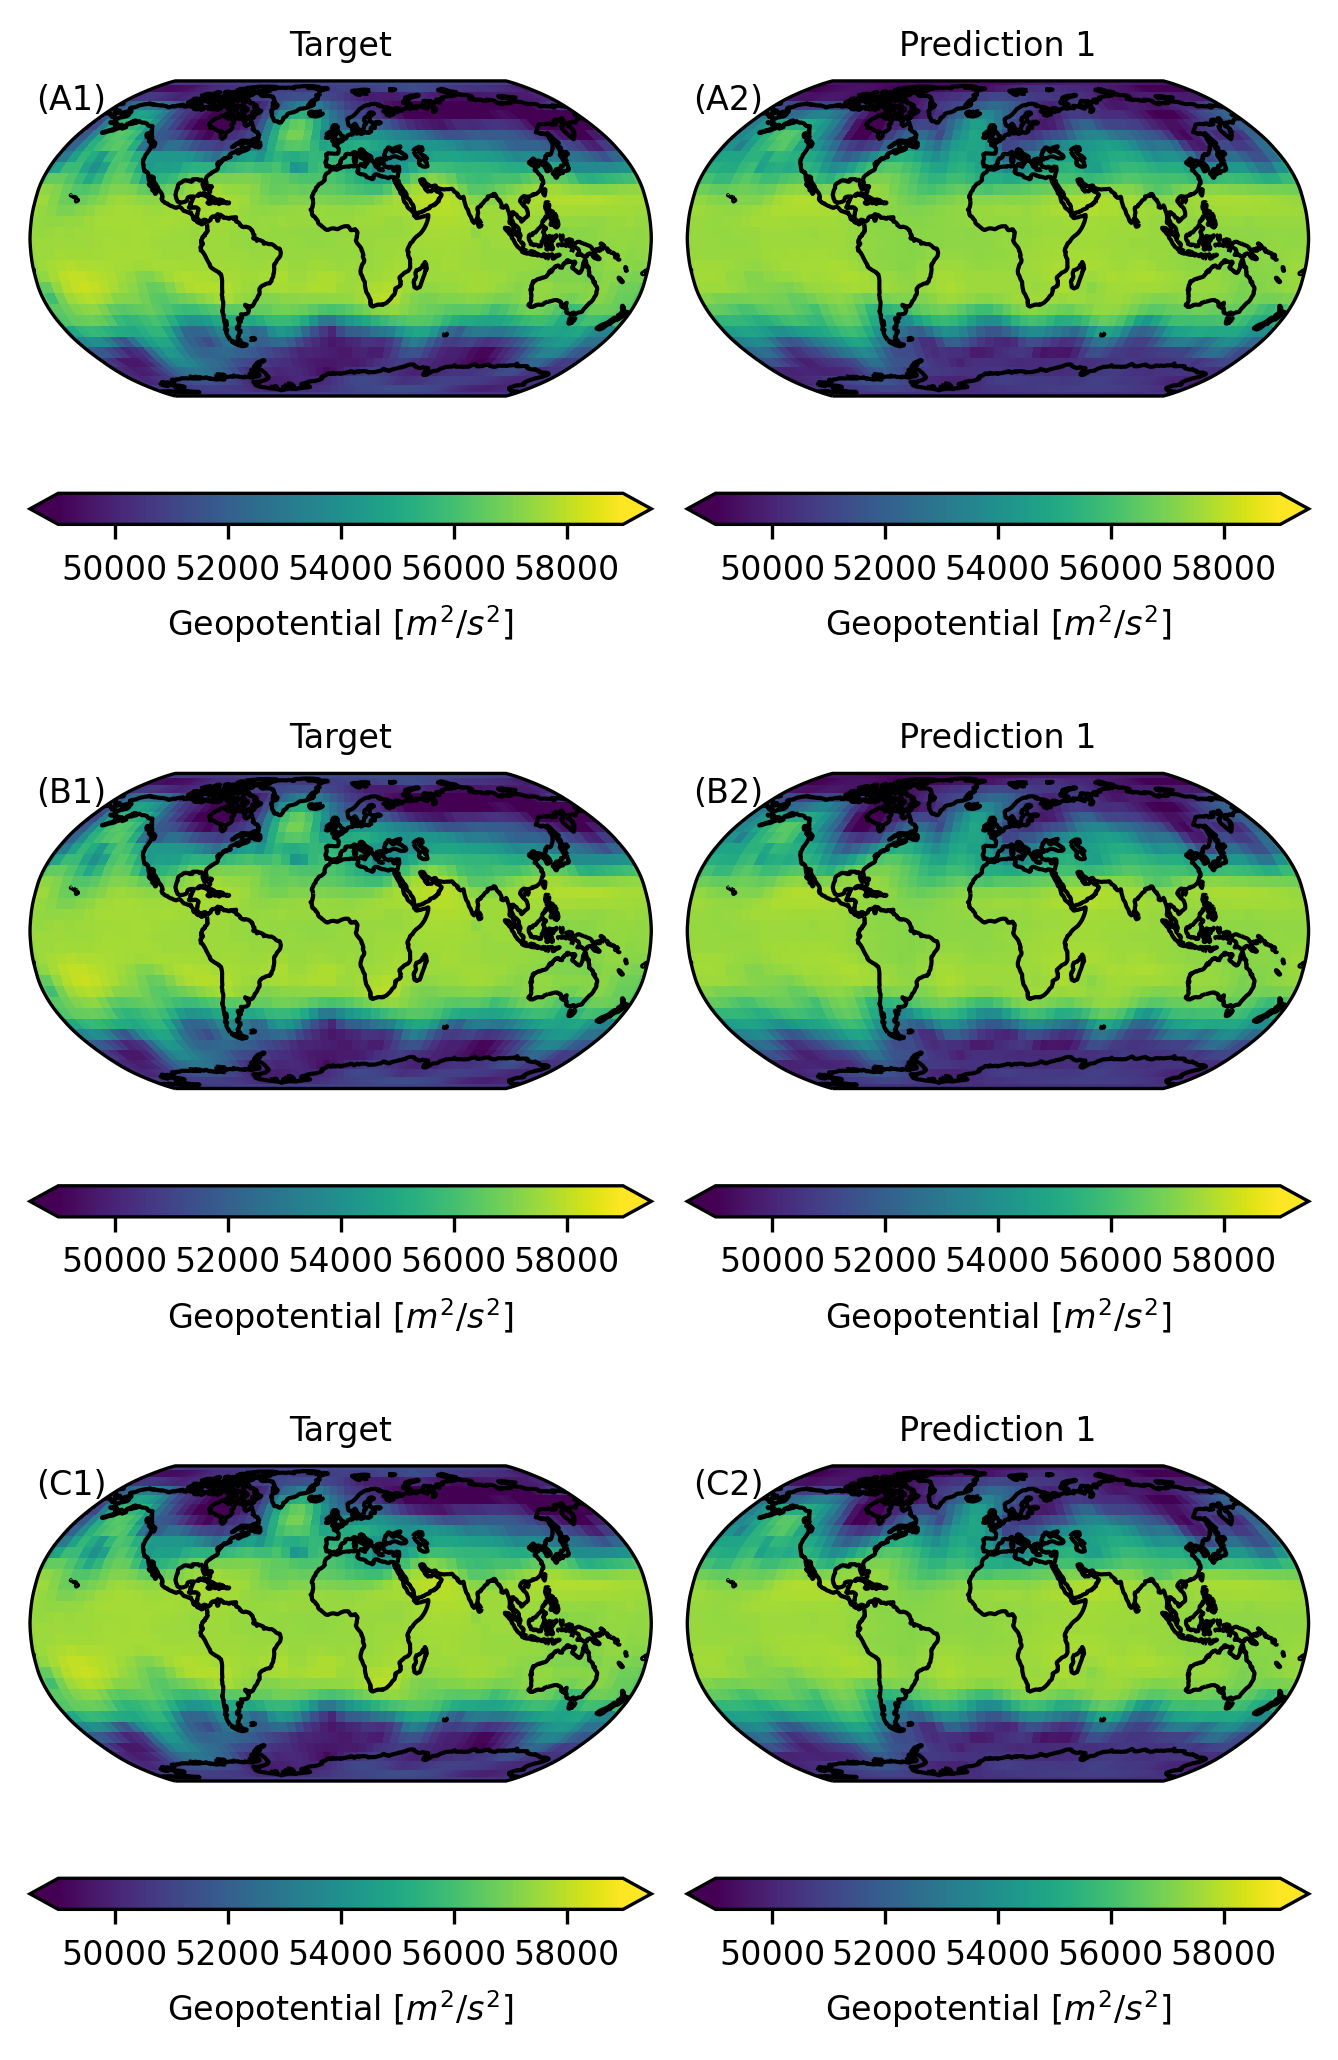

In [13]:
n_rows = n_images
n_cols = 3

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = 1.3 * textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1,1,1])

for i, i_t in enumerate(timesteps):
    ax = fig.add_subplot(gs[i, 0], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=targets_experiments["30604C"].isel({"init_time":i_t, "lead_time":0, "ensemble_member":0})[list(targets_experiments["30604C"].keys())], plotting_config=config, title="Target")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}1)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 1], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=predictions_experiments["30604C"].isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(predictions_experiments["30604C"].keys())], plotting_config=config, title="Prediction 1")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}2)".format(alphabet_letters[i]))


fig.canvas.draw()
fig.tight_layout()

plt.show()

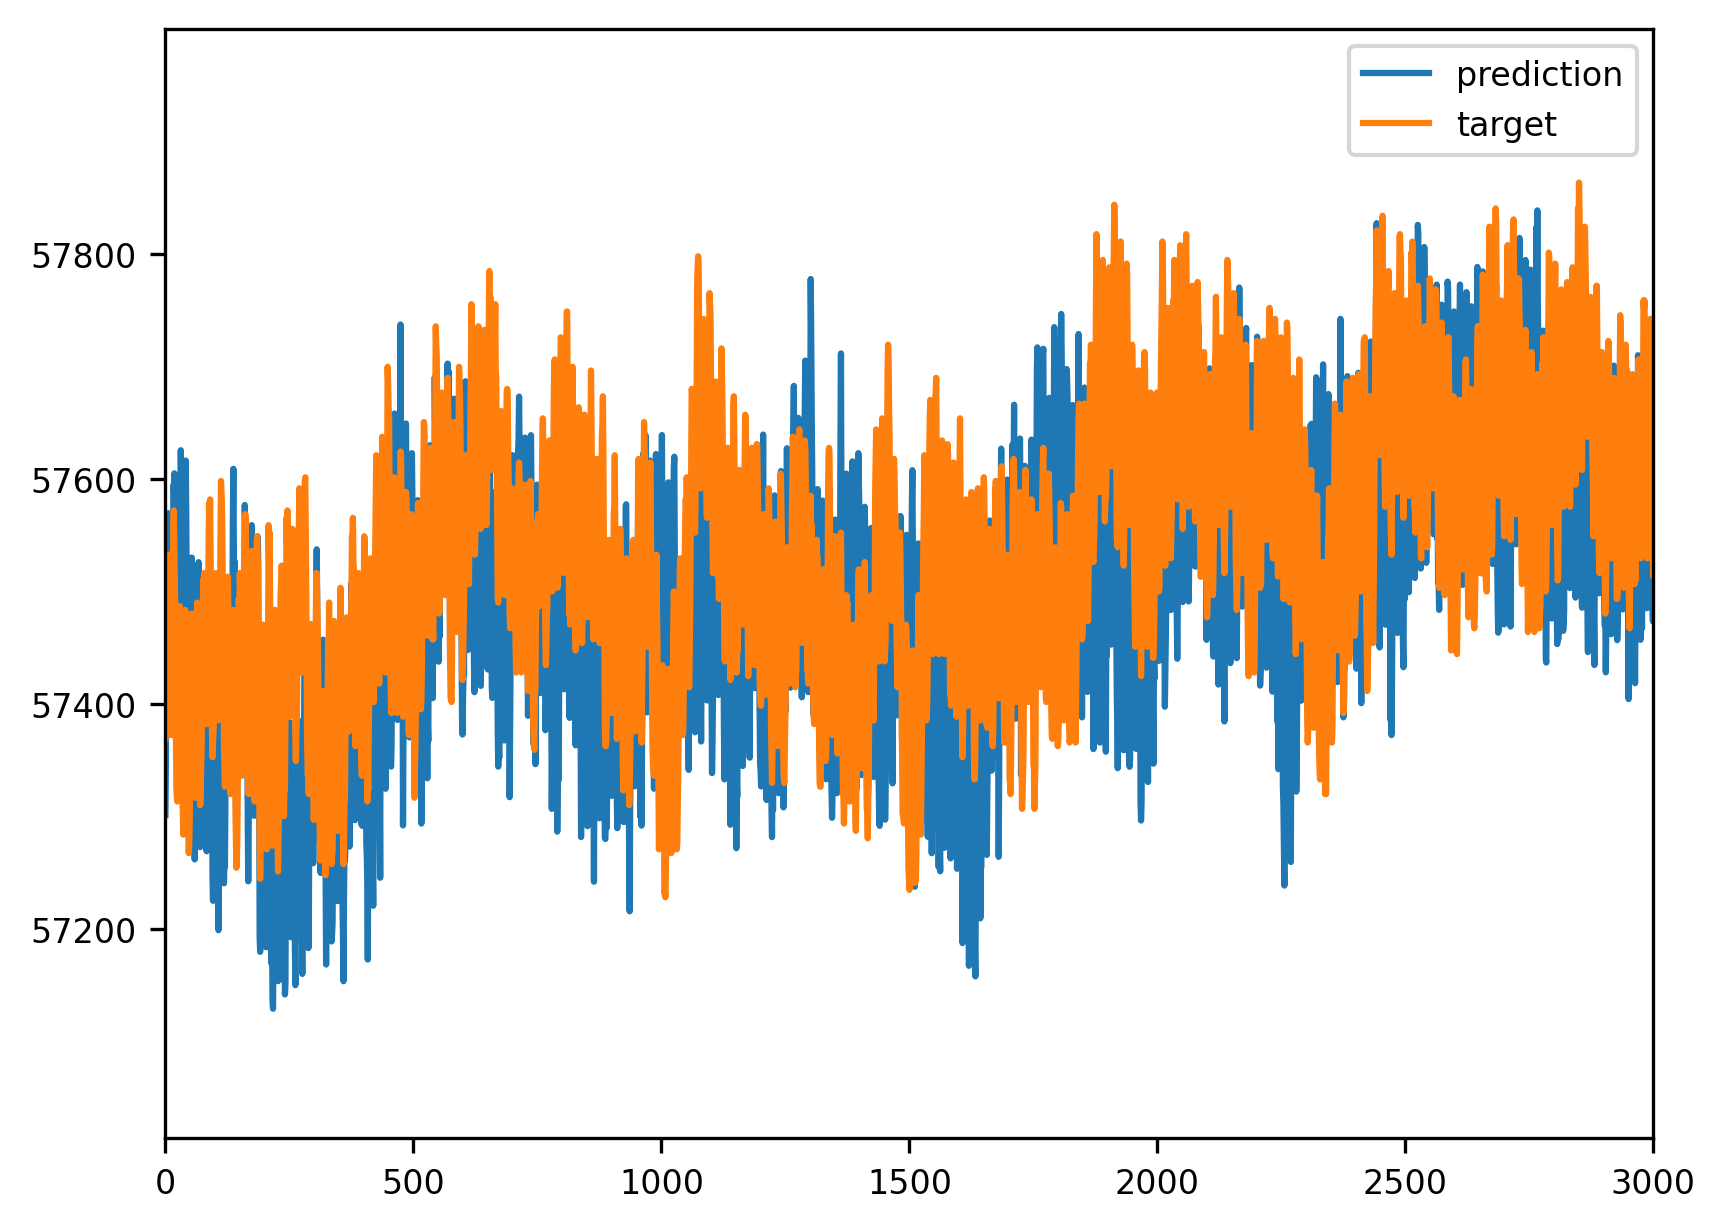

In [26]:
plt.plot(predictions_experiments["30604C"].isel({"lead_time":0, "ensemble_member": 0, "lat":15, "lon":60}).z_500, label="prediction")
plt.plot(targets_experiments["30604C"].isel({"lead_time":0, "ensemble_member": 0, "lat":15, "lon":60}).z_500, label="target")
plt.xlim(0, 3000)
plt.legend()
plt.show()

# RMSE maps

In [21]:
config_rmse = copy.deepcopy(config)

config_rmse["CMAP"] = "Reds"
config_rmse["NORM"] = matplotlib.colors.Normalize(vmin=0, vmax=3000)

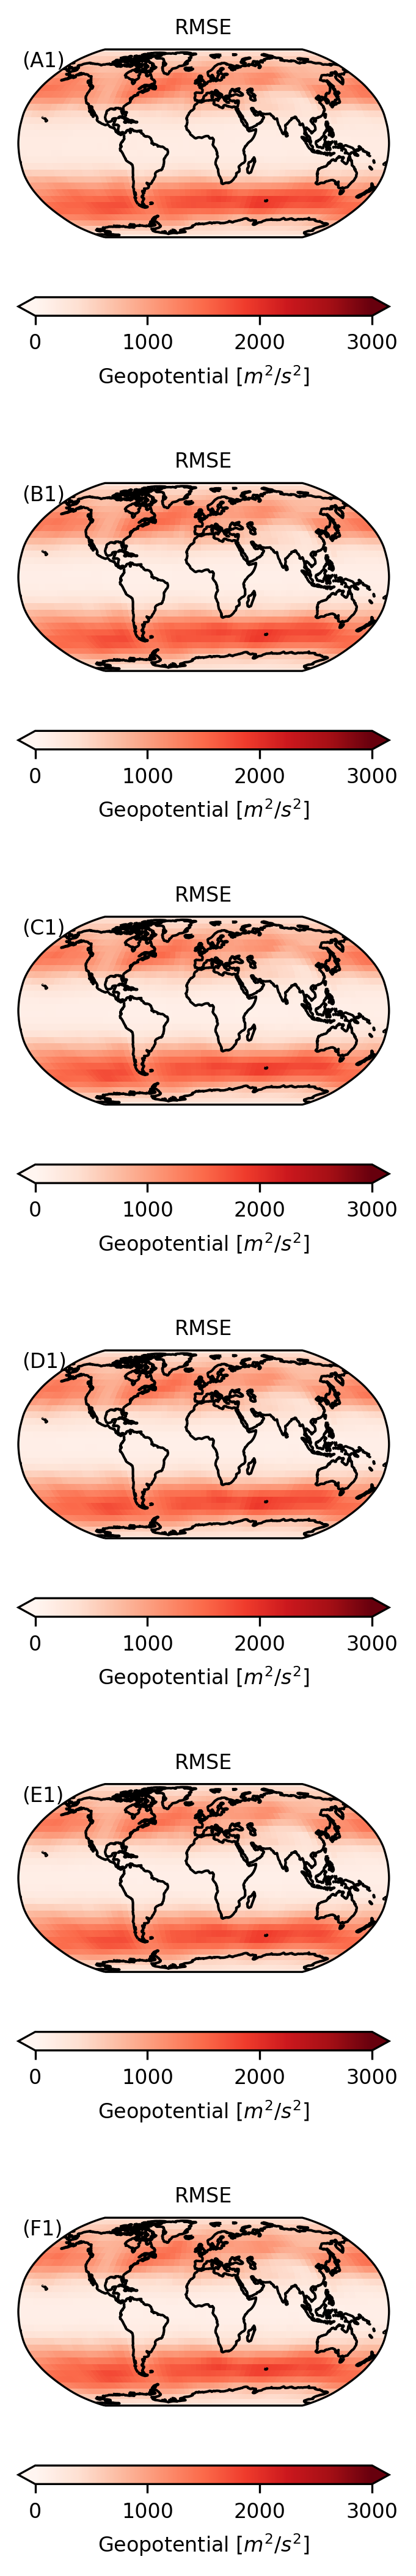

In [22]:
n_rows = len(model_ids)
n_cols = 3

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = 1.3 * textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1,1,1])

for i, m in enumerate(model_ids_mse_loss):
    ax = fig.add_subplot(gs[i, 0], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=rmse_maps[m], plotting_config=config_rmse, title="RMSE")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}1)".format(alphabet_letters[i]))


fig.canvas.draw()
fig.tight_layout()

plt.show()

In [1]:
from WD.datasets import Conditional_Dataset_Zarr_Iterable, Conditional_Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import zarr

In [54]:
ds = Conditional_Dataset_Zarr_Iterable("/data/compoundx/WeatherDiff/model_input/9B00C6_train.zarr", "/data/compoundx/WeatherDiff/config_file/9B00C6.yml")

In [55]:
ds2 = Conditional_Dataset("/data/compoundx/WeatherDiff/model_input/278771_train.pt", "/data/compoundx/WeatherDiff/config_file/278771.yml")

In [5]:
ds_id = "9B00C6"
model_id = "DEB681"

In [6]:
predictions_experiments = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_gen.nc")
targets_experiments = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_target.nc")

In [8]:
compute_weighted_rmse(predictions_experiments.isel({"ensemble_member":0}), targets_experiments.isel({"ensemble_member":0})).z_500

<xarray.DataArray 'z_500' ()>
array(854.62390975)
Coordinates:
    ensemble_member  int64 0

In [9]:
rmse

NameError: name 'rmse' is not defined

In [7]:
predictions_experiments.init_time

<xarray.DataArray 'init_time' (init_time: 2905)>
array(['1970-01-01T00:00:00.000333120', '1970-01-01T00:00:00.000333126',
       '1970-01-01T00:00:00.000333132', ..., '1970-01-01T00:00:00.000350532',
       '1970-01-01T00:00:00.000350538', '1970-01-01T00:00:00.000350544'],
      dtype='datetime64[ns]')
Coordinates:
  * init_time  (init_time) datetime64[ns] 1970-01-01T00:00:00.000333120 ... 1...

In [43]:
ds = xr.Dataset()

In [49]:
time_da = xr.open_zarr("/home/wider/Projects/diffusion-models-for-weather-prediction/test.zarr").timedd

In [51]:
ds.expand_dims(init_time=time_da)

<xarray.Dataset>
Dimensions:    (init_time: 8784)
Coordinates:
  * init_time  (init_time) datetime64[ns] 1980-01-01 ... 1980-12-31T23:00:00
Data variables:
    *empty*

In [64]:
ds_ref = xr.open_mfdataset("/data/compoundx/WeatherBench/geopotential_500/*.nc")

In [172]:
a = ds_ref.isel({"lat":15, "lon":60}).sel({"time": slice(datetime.strptime("2017-01-01 00:00:00", "%Y-%m-%d %H:%M:%S"), datetime.strptime("2018-12-31 00:00:00", "%Y-%m-%d %H:%M:%S"))}).z.values



b = targets_experiments.mean(("lead_time", "ensemble_member", "lat", "lon")).z_500
c = predictions_experiments.mean(("lead_time", "ensemble_member", "lat", "lon")).z_500


In [164]:
ds_ref.mean(("lat","lon")).drop_coordina

<xarray.Dataset>
Dimensions:  (time: 350640)
Coordinates:
    level    int32 500
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time) float32 dask.array<chunksize=(8760,), meta=np.ndarray>

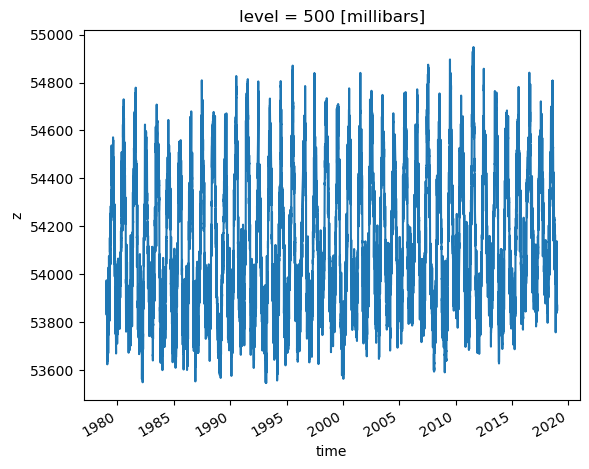

In [161]:
ds_ref.mean(("lat","lon")).z.plot()

In [167]:
predictions_experiments.isel({"init_time": slice(2,-26)})

<xarray.Dataset>
Dimensions:          (lat: 32, lon: 64, lead_time: 1, ensemble_member: 1,
                      init_time: 2877)
Coordinates:
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * lead_time        (lead_time) int64 12
  * ensemble_member  (ensemble_member) int64 0
  * init_time        (init_time) datetime64[ns] 1970-01-01T00:00:00.000333132...
Data variables:
    z_500            (ensemble_member, init_time, lead_time, lat, lon) float32 ...

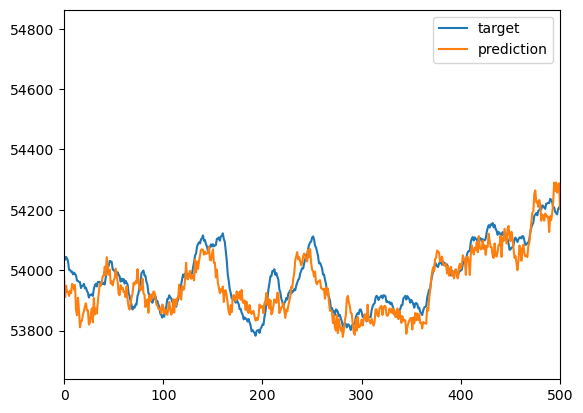

In [175]:
# plt.plot(a[::6], label="original dataset")
plt.plot(b, label="target")
plt.plot(c, label="prediction")

plt.xlim(0,500)
plt.legend()
plt.show()

In [174]:
zarr_path="/data/compoundx/WeatherDiff/model_input/9B00C6_train.zarr/targets"

In [155]:
xr.open_zarr(zarr_path)

<xarray.Dataset>
Dimensions:   (time: 54049, variable: 1, lat: 32, lon: 64)
Coordinates:
  * lat       (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon       (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time      (time) datetime64[ns] 1979-01-02 ... 2015-12-31
  * variable  (variable) object 'z_500'
Data variables:
    data      (time, variable, lat, lon) float32 dask.array<chunksize=(54049, 1, 32, 64), meta=np.ndarray>

In [153]:
zarr.open(zarr_path).info

Name,/
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,3
No. arrays,0
No. groups,3
Groups,"constants, inputs, targets"
